In [54]:
# Course work

In [55]:
# Load libs

import numpy as np
import pandas as pd
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [56]:
# 0. preparation

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 12})

TRAIN_DATASET_PATH = 'input_data/course_project_train.csv'
TEST_DATASET_PATH = 'input_data/course_project_test.csv'

In [57]:
# model evaluation
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [58]:
# target balancing
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [59]:
# 1. load data and know the data

In [60]:
# load train
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [61]:
# load test

test_df.tail()


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [62]:
# work with types
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [63]:
print(train_df.shape)
print(test_df.shape)

(7500, 17)
(2500, 16)


In [64]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)


feature_obj_names = {'Home Ownership', 'Years in current job', 'Purpose', 'Term'}
for el in feature_obj_names:
    train_df[el] = train_df[el].astype(str)
train_df.dtypes

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.58 MB
Decreased by 40.4%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.19 MB
Decreased by 37.5%


Home Ownership                   object
Annual Income                   float32
Years in current job             object
Tax Liens                       float32
Number of Open Accounts         float32
Years of Credit History         float32
Maximum Open Credit             float32
Number of Credit Problems       float32
Months since last delinquent    float32
Bankruptcies                    float32
Purpose                          object
Term                             object
Current Loan Amount             float32
Current Credit Balance          float32
Monthly Debt                    float32
Credit Score                    float32
Credit Default                     int8
dtype: object

In [65]:

# 1. Target Credit Default
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

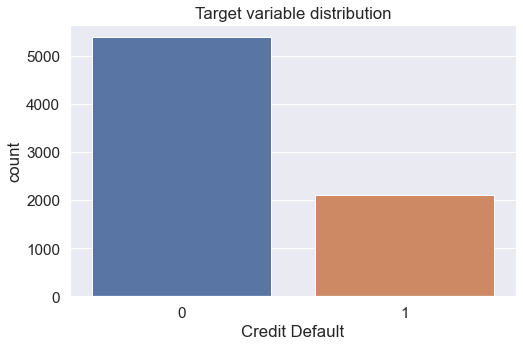

In [66]:

plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Target variable distribution')
plt.show()

# Imbalanced Classes

In [67]:
# 2. Describe features
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [68]:
df_num_features = train_df.select_dtypes(include=['float32', 'int32', 'int16', 'int8'])
df_cat_features = train_df.select_dtypes(include='object')
df_num_features.drop('Credit Default', axis=1, inplace=True)

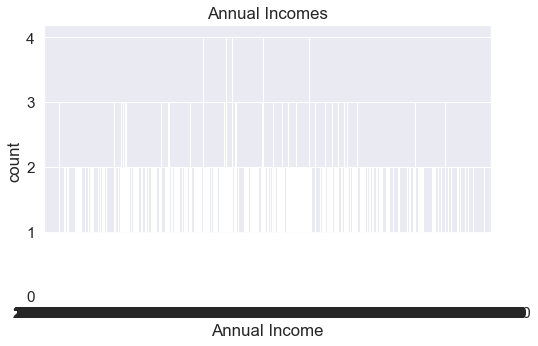

In [69]:
plt.figure(figsize=(8, 5))

sns.countplot(x=train_df['Annual Income'], data=train_df)

plt.title('Annual Incomes')
plt.show()

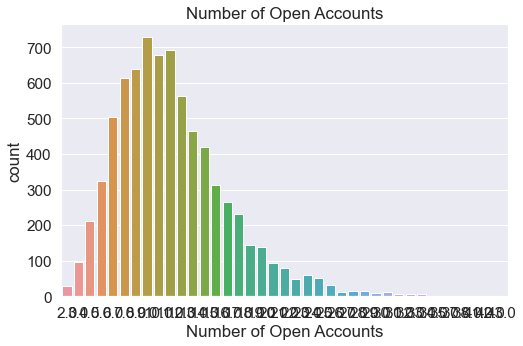

In [70]:
plt.figure(figsize=(8, 5))

sns.countplot(x=train_df['Number of Open Accounts'], data=train_df)

plt.title('Number of Open Accounts')
plt.show()
# outlier

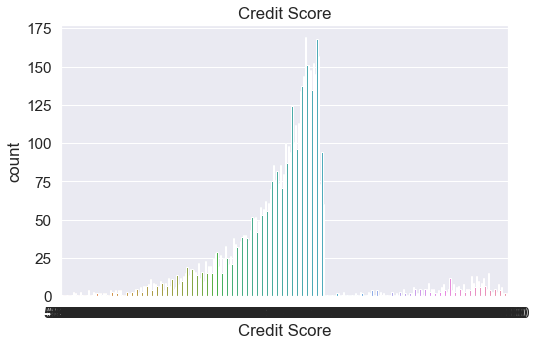

In [71]:
plt.figure(figsize=(8, 5))

sns.countplot(x=train_df['Credit Score'], data=train_df)

plt.title('Credit Score')
plt.show()
# outlier

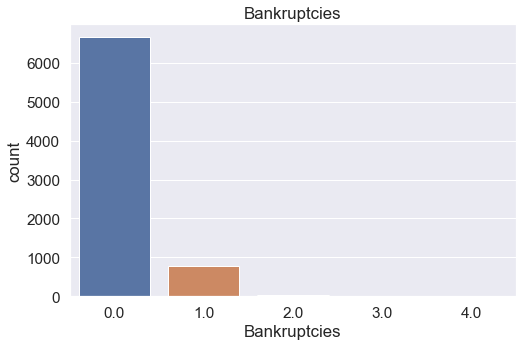

In [72]:

plt.figure(figsize=(8, 5))

sns.countplot(x=train_df['Bankruptcies'], data=train_df)

plt.title('Bankruptcies')
plt.show()
# outlier: more than 1 change 1

In [73]:
for cat_colname in df_cat_features.columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
# Years in current job has nan, set equal to -1 because there is no work. 
# Categories: -1(nan), 1(<1 year, 1 year), 3(2-3 years), 5(4-5 years), 7(6-7 years), 9(8-9 years), 10(10+ years)

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

In [74]:
# NaN
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [75]:
class DataPreprocessing:

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.moda = None
        self.credit_score_quantile = None
        self.open_accounts_quantile = None
        
    def fit(self, df):
        """Statistics saving"""
        
        # Расчет медиан 
        self.medians = df[['Number of Open Accounts', 'Credit Score', 'Annual Income']].median()
        self.open_accounts_quantile = df['Number of Open Accounts'].quantile(.975)
        self.credit_score_quantile = df['Credit Score'].quantile(.975)


   
    def transform(self, df):
        """Data Transform"""
        
        df_num_features = df.select_dtypes(include=['float32', 'int32', 'int16', 'int8'])
        df_cat_features = df.select_dtypes(include='object')

        # 1. NAN
        df[['Annual Income', 'Credit Score']] = df[['Annual Income', 'Credit Score']].fillna(self.medians)
        df[['Bankruptcies']] = df[['Bankruptcies']].fillna(0)
        df[['Months since last delinquent']] = df[['Months since last delinquent']].fillna(0)
        df.loc[df['Years in current job'] == 'nan', 'Years in current job'] = 'No'
 
        # 2. Outliers
    
        # Number of Open Accounts
        condition = (df['Number of Open Accounts'].isna()) | (df['Number of Open Accounts'] > self.open_accounts_quantile)        
        df.loc[condition, 'Number of Open Accounts'] = self.medians['Number of Open Accounts']

        # Credit Score
        condition = (df['Credit Score'].isna()) | (df['Credit Score'] > self.credit_score_quantile)        
        df.loc[condition, 'Credit Score'] = self.medians['Credit Score']

        # Bankruptcies
        df.loc[df['Bankruptcies'] > 1, 'Bankruptcies'] = 1

        #3. Categorial coding and new features
        
        #Term
        cat_dict_term = {'Short Term': 0, 'Long Term': 1}
        df['Term_bin'] = df['Term'].map(cat_dict_term).astype(int)
        
        #Home Ownership
        condition = (df['Home Ownership'].isna()) | (df['Home Ownership'] == 'Have Mortgage')        
        df.loc[condition, 'Home Ownership'] = 'Home Mortgage'
        df['Home Ownership size'] = df['Home Ownership'].map(df.groupby('Home Ownership').size())        
        
        #Years in current job
        cat_dict_current_job = {'No': -1, '10+ years': 10, '2 years': 3, '3 years': 3, '< 1 year': 1, '5 years': 5, \
                         '1 year': 1, '4 years': 5, '6 years': 7, '7 years': 7, '8 years': 9, '9 years': 9}
        df['Years in current job cat'] = df['Years in current job'].map(cat_dict_current_job)
        
        #Purpose
        condition = (df['Purpose'].isna()) | (df['Purpose'] == 'renewable energy')        
        df.loc[condition, 'Purpose'] = 'other'
        condition = (df['Purpose'] == 'take a trip')        
        df.loc[condition, 'Purpose'] = 'vacation'
        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix=cat_colname)], axis=1)
        
        return df

    
    
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business,Term_vacation,Term_wedding
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000
mean,1.325285e+06,0.030133,10.741734,18.317446,9.451526e+05,0.1700,15.815200,0.110133,11873135.0,2.898332e+05,...,0.792533,0.001333,0.054933,0.005333,0.009467,0.001467,0.088933,0.003467,0.006000,0.00200
std,7.567584e+05,0.271613,4.222326,7.041938,1.602614e+07,0.4986,22.648802,0.313080,31926302.0,3.178713e+05,...,0.405520,0.036493,0.227865,0.072840,0.096842,0.038272,0.284666,0.058780,0.077232,0.04468
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,0.000000,0.000000,180169.0,1.142565e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,0.000000,0.000000,309573.0,2.093230e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.499974e+06,0.000000,13.000000,21.799999,7.935015e+05,0.0000,29.000000,0.000000,519882.0,3.604062e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.014934e+07,7.000000,23.000000,57.700001,1.304726e+09,7.0000,118.000000,1.000000,100000000.0,6.506797e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [76]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business,Term_vacation,Term_wedding
count,2500.00,2500.00000,2500.00000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.0,2.500000e+03,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.00000,2500.000000,2500.000000,2500.000000
mean,1326182.25,0.03520,10.85880,18.325901,7.105701e+05,0.162000,15.614000,0.098000,12155693.0,2.963965e+05,...,0.789200,0.001200,0.056000,0.003600,0.010800,0.0004,0.09600,0.002000,0.006800,0.000800
std,821517.25,0.38629,4.25767,7.254657,1.511983e+06,0.559895,22.616343,0.297371,32261024.0,3.783021e+05,...,0.407958,0.034627,0.229968,0.059904,0.103381,0.0200,0.29465,0.044686,0.082198,0.028279
min,106533.00,0.00000,1.00000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,15422.0,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000
25%,936562.25,0.00000,8.00000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,187126.5,1.101145e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000
50%,1168386.00,0.00000,10.00000,17.000000,4.786760e+05,0.000000,0.000000,0.000000,322366.0,2.073850e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000
75%,1488726.00,0.00000,13.00000,22.100000,8.025985e+05,0.000000,27.000000,0.000000,522582.5,3.663485e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000
max,14975610.00,15.00000,23.00000,53.400002,5.448438e+07,15.000000,82.000000,1.000000,100000000.0,6.030087e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000,1.000000,1.000000


In [77]:
len(train_df) - train_df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Term_bin                        0
Home Ownership size             0
Years in current job cat        0
Term_business loan              0
Term_buy a car                  0
Term_buy house                  0
Term_debt consolidation         0
Term_educational expenses       0
Term_home improvements          0
Term_major purchase             0
Term_medical bills              0
Term_moving                     0
Term_other    

In [78]:
df_num_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,100000000.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,100000000.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,100000000.0,477812.0,12479.0,748.0
7498,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN


In [79]:
# 3. EDA
df_new_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int32', 'int16', 'int8', 'uint8'])
df_new_features
# train_df.dtypes

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business,Term_vacation,Term_wedding
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,100000000.0,47386.0,...,1,0,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,264968.0,394972.0,...,1,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.000000,1182434.0,0.0,0.0,0.0,100000000.0,308389.0,...,1,0,0,0,0,0,0,0,0,0
3,805068.0,0.0,8.0,22.500000,147400.0,1.0,0.0,1.0,121396.0,95855.0,...,1,0,0,0,0,0,0,0,0,0
4,776264.0,0.0,13.0,13.600000,385836.0,1.0,0.0,0.0,125840.0,93309.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.500000,107866.0,0.0,0.0,0.0,129360.0,73492.0,...,0,0,0,0,0,0,1,0,0,0
7496,1533984.0,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,444048.0,456399.0,...,1,0,0,0,0,0,0,0,0,0
7497,1878910.0,0.0,12.0,32.099998,1778920.0,0.0,0.0,0.0,100000000.0,477812.0,...,0,0,0,0,0,0,0,0,0,0
7498,1168386.0,0.0,21.0,26.500000,1141250.0,0.0,0.0,0.0,615274.0,476064.0,...,1,0,0,0,0,0,0,0,0,0


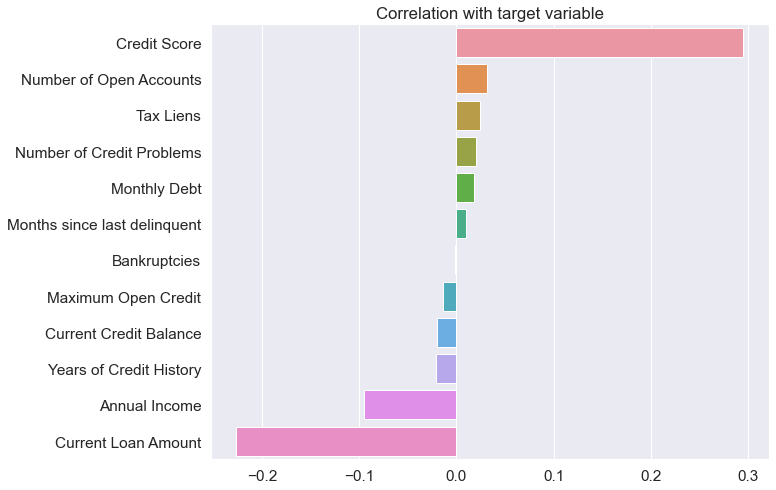

In [80]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Term_business loan', 'Term_buy a car', 'Term_buy house', 'Term_debt consolidation', 'Term_educational expenses', 'Term_home improvements', 'Term_major purchase', 'Term_medical bills', 'Term_moving', 'Term_other', 'Term_small business', 'Term_vacation', 'Term_wedding']


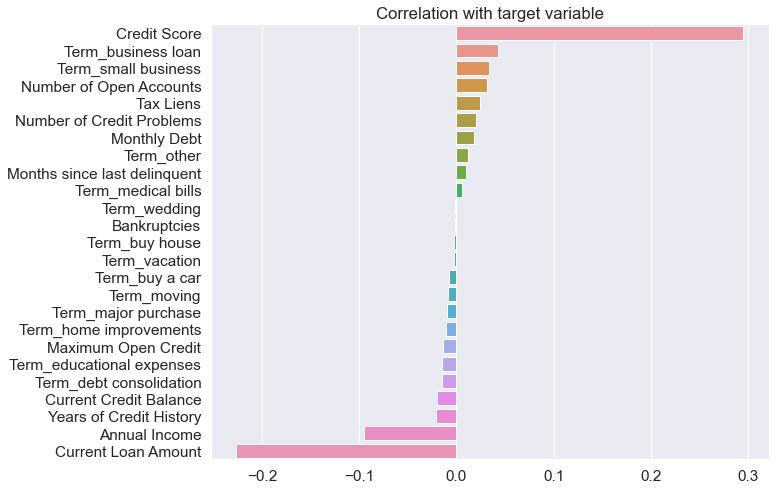

In [81]:
NEW_FEATURE_NAMES = df_new_features.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES_WITHOUT_Bankruptcies = df_new_features.columns.drop(TARGET_NAME, 'Bankruptcies').tolist()
print(NEW_FEATURE_NAMES)

corr_with_target = train_df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()
# 'Term_vacation', 'Term_wedding', 'Term_buy house', 'Term_medical bills, 'Term_buy a car', 'Term_moving', 'Bankruptcies' - no correlation with target

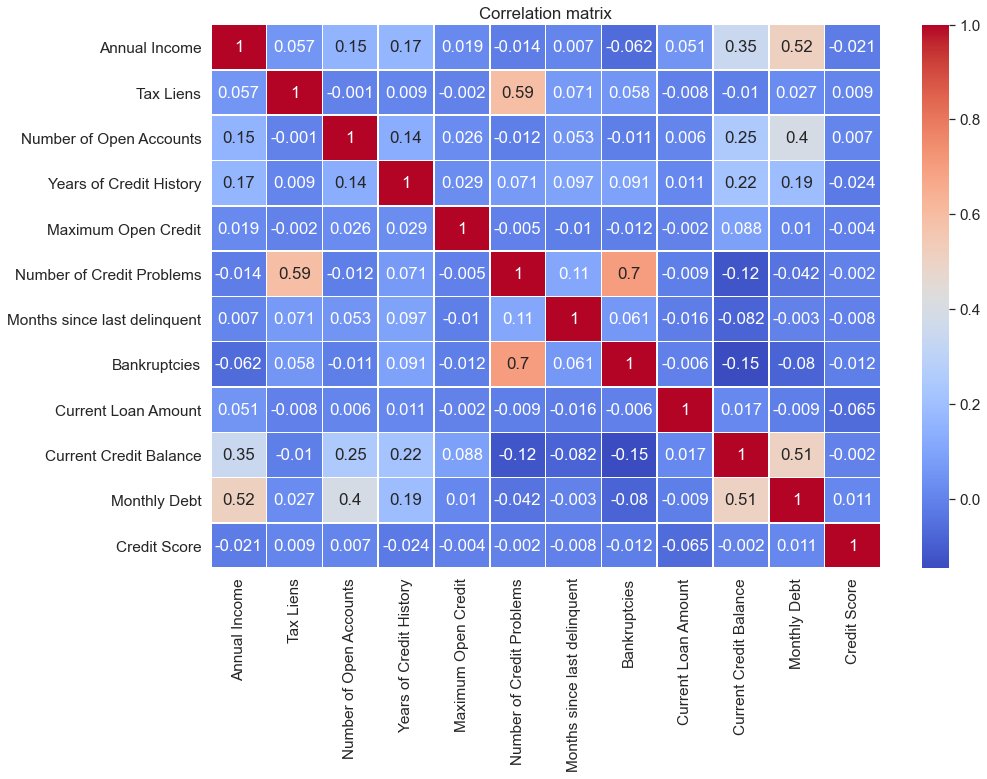

In [82]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
sns.heatmap(train_df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()
# 'Tax Liens' correlation with "number of credit problems"

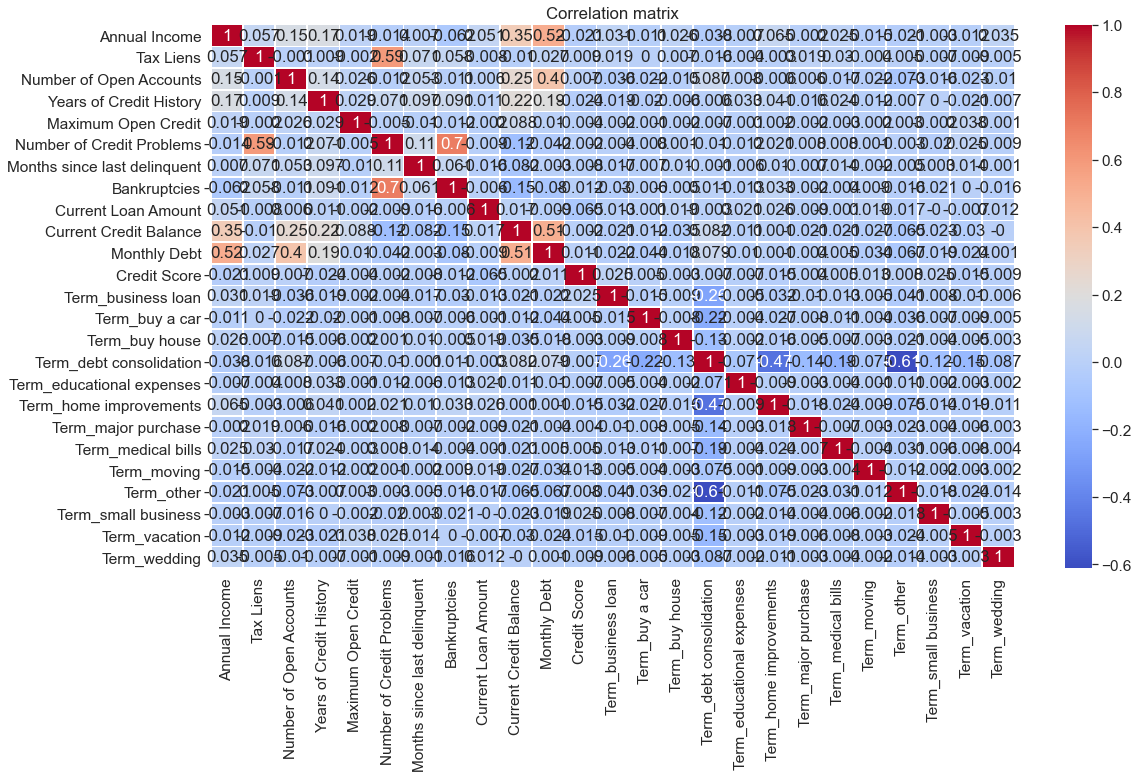

In [83]:
plt.figure(figsize = (18,10))

sns.set(font_scale=1.4)
sns.heatmap(train_df[NEW_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

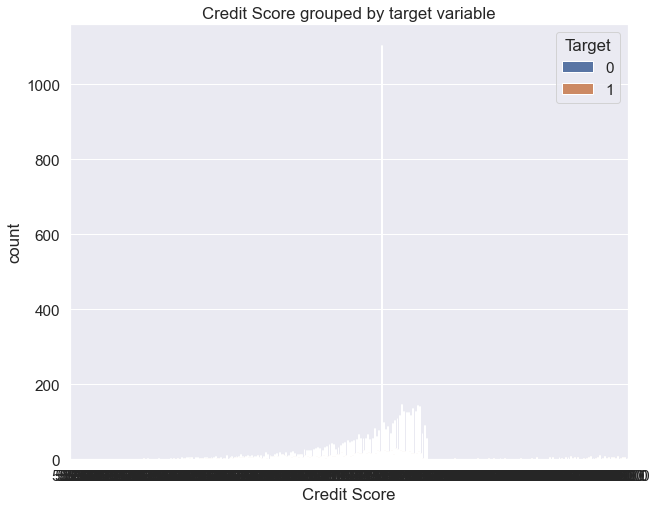

In [84]:
# hypothesis: the Credit Default depends on the Credit Score
#
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=train_df)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()
# not right hypothesis

In [85]:
# 4. Feature selection
# # 'Tax Liens', 'Term_vacation', 'Term_wedding', 'Term_buy house', 'Bankruptcies' - no correlation with target
NEW_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
                     'Credit Score', 'Term_business loan', 'Term_buy a car', 
                     'Term_debt consolidation', 'Term_educational expenses', 'Term_home improvements', 
                     'Term_major purchase', 'Term_medical bills', 'Term_moving', 
                     'Term_other', 'Term_small business']

NEW_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Term_business loan',
 'Term_buy a car',
 'Term_debt consolidation',
 'Term_educational expenses',
 'Term_home improvements',
 'Term_major purchase',
 'Term_medical bills',
 'Term_moving',
 'Term_other',
 'Term_small business']

In [86]:
# 5. Standartization

scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NEW_FEATURE_NAMES] = scaler.fit_transform(df_norm[NEW_FEATURE_NAMES])

train_df = df_norm.copy()
train_df[NEW_FEATURE_NAMES].head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Term_business loan,Term_buy a car,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business
0,-1.114304,-0.110953,0.061171,1.133645,-0.016174,1.664779,-0.698307,2.760520,-0.762772,-0.872085,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
1,-0.396190,-0.110953,1.008578,-0.428528,0.014763,-0.340979,-0.698307,-0.363620,0.330781,0.004909,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
2,-0.758385,-0.110953,0.061171,2.369181,0.014807,-0.340979,-0.698307,2.760520,0.058379,-0.391034,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
3,-0.687478,-0.110953,-0.649384,0.593985,-0.049781,1.664779,-0.698307,-0.368118,-0.610282,-0.584980,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
4,-0.725543,-0.110953,0.534875,-0.669954,-0.034903,1.664779,-0.698307,-0.367978,-0.618292,-0.933631,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981


In [87]:
# 6. train test Separation

X = train_df[NEW_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_test = test_df[NEW_FEATURE_NAMES]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)
print(X_train.shape)
# (7500, 25)
print(X_test.shape) #(2500, 25)

(5625, 21)
(2500, 21)


In [88]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [89]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [90]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

X_train.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Term_business loan,Term_buy a car,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business
5729,-0.386699,-0.110953,0.298023,-0.030884,-0.035498,-0.340979,-0.698307,-0.365110,-0.490609,-0.669753,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
812,-0.207346,-0.110953,1.719134,0.082729,-0.047729,-0.340979,1.376938,-0.354492,-0.617455,-0.416943,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
81,-0.207346,-0.110953,0.061171,0.991629,-0.018078,-0.340979,1.509401,-0.356397,-0.165664,0.652236,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
673,-0.207346,-0.110953,-1.123088,-0.030884,-0.004081,-0.340979,-0.698307,-0.364981,-0.321441,-0.388602,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981
2186,-0.912102,-0.110953,-0.175681,1.204653,-0.030444,1.664779,-0.698307,-0.364230,-0.352764,-0.226519,...,-0.132291,-0.113868,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.312433,-0.058981


In [91]:
# 7. Building and evaluating baseline models
# Logistic Regression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.40 for 1 for X_valid

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.86      0.73      4074
           1       0.65      0.36      0.46      3102

    accuracy                           0.64      7176
   macro avg       0.64      0.61      0.60      7176
weighted avg       0.64      0.64      0.61      7176

TEST

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1313
           1       0.49      0.34      0.40       562

    accuracy                           0.70      1875
   macro avg       0.62      0.59      0.60      1875
weighted avg       0.67      0.70      0.68      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1118  195
1                373  189


In [92]:
# k nearest neighbors
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.40 for 1 for X_valid

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4074
           1       0.77      0.70      0.73      3102

    accuracy                           0.78      7176
   macro avg       0.78      0.77      0.77      7176
weighted avg       0.78      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1313
           1       0.40      0.41      0.40       562

    accuracy                           0.64      1875
   macro avg       0.57      0.57      0.57      1875
weighted avg       0.64      0.64      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               967  346
1               332  230


In [93]:
# XGBoost
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.48 for 1 for X_valid

[11:26:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4074
           1       0.97      0.96      0.97      3102

    accuracy                           0.97      7176
   macro avg       0.97      0.97      0.97      7176
weighted avg       0.97      0.97      0.97      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1313
           1       0.54      0.44      0.48       562

    accuracy                           0.72      1875
   macro avg       0.66      0.64      0.64      1875
weighted avg       0.71    

In [94]:
# LightGBM
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.50 for 1 for X_valid
print(y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4074
           1       0.92      0.90      0.91      3102

    accuracy                           0.92      7176
   macro avg       0.92      0.92      0.92      7176
weighted avg       0.92      0.92      0.92      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1313
           1       0.54      0.49      0.51       562

    accuracy                           0.72      1875
   macro avg       0.67      0.66      0.66      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  230
1                289  273
[1 0 0 ... 0 0 0]


In [95]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.50 for 1 for X_valid

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4074
           1       0.91      0.85      0.87      3102

    accuracy                           0.90      7176
   macro avg       0.90      0.89      0.89      7176
weighted avg       0.90      0.90      0.89      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1313
           1       0.52      0.45      0.48       562

    accuracy                           0.71      1875
   macro avg       0.65      0.64      0.64      1875
weighted avg       0.70      0.71      0.70      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1081  232
1                309  253


In [96]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.26 for 1 for X_valid

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.98      0.75      4074
           1       0.87      0.15      0.26      3102

    accuracy                           0.62      7176
   macro avg       0.74      0.57      0.51      7176
weighted avg       0.72      0.62      0.54      7176

TEST

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      1313
           1       0.78      0.16      0.26       562

    accuracy                           0.73      1875
   macro avg       0.76      0.57      0.55      1875
weighted avg       0.75      0.73      0.67      1875

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1288  25
1                473  89


In [97]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_train_pred = gnb.predict(X_train)
y_valid_pred = gnb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.26 for 1 for X_valid

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.22      0.36      4074
           1       0.49      0.96      0.64      3102

    accuracy                           0.54      7176
   macro avg       0.68      0.59      0.50      7176
weighted avg       0.71      0.54      0.48      7176

TEST

              precision    recall  f1-score   support

           0       0.95      0.23      0.38      1313
           1       0.35      0.97      0.52       562

    accuracy                           0.45      1875
   macro avg       0.65      0.60      0.45      1875
weighted avg       0.77      0.45      0.42      1875

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               307  1006
1                17   545


In [98]:
# The best model - LightGBM
# model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
# 8. Select the best param

In [99]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

gs = GridSearchCV(model_catb, params, 
                  scoring='f1', 
                  cv=KFold(n_splits=5,
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_ #{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

0.841886907671704


{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

In [105]:
model_catb = catb.CatBoostClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

# model_lgbm = lgbm.LGBMClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=21)
# model_lgbm.fit(X_train, y_train)

# y_train_pred = model_lgbm.predict(X_train)
# y_valid_pred = model_lgbm.predict(X_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)
# f1 = 0.47 for 1 for X_valid
# the best params for test dataset - without params

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1313
           1       0.56      0.36      0.44       562

    accuracy                           0.72      1875
   macro avg       0.66      0.62      0.63      1875
weighted avg       0.70      0.72      0.70      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1152  161
1                358  204


In [101]:
X_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Term_business loan,Term_buy a car,Term_debt consolidation,Term_educational expenses,Term_home improvements,Term_major purchase,Term_medical bills,Term_moving,Term_other,Term_small business
count,2500.00,2500.00000,2500.00000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.0,2.500000e+03,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.00000,2500.000000
mean,1326182.25,0.03520,10.85880,18.325901,7.105701e+05,0.162000,15.614000,12155693.0,2.963965e+05,18271.304688,...,0.012000,0.013600,0.789200,0.001200,0.056000,0.003600,0.010800,0.0004,0.09600,0.002000
std,821517.25,0.38629,4.25767,7.254657,1.511983e+06,0.559895,22.616343,32261024.0,3.783021e+05,11543.883789,...,0.108907,0.115846,0.407958,0.034627,0.229968,0.059904,0.103381,0.0200,0.29465,0.044686
min,106533.00,0.00000,1.00000,3.900000,0.000000e+00,0.000000,0.000000,15422.0,0.000000e+00,93.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000
25%,936562.25,0.00000,8.00000,13.400000,2.785860e+05,0.000000,0.000000,187126.5,1.101145e+05,10024.750000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000
50%,1168386.00,0.00000,10.00000,17.000000,4.786760e+05,0.000000,0.000000,322366.0,2.073850e+05,16642.500000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000
75%,1488726.00,0.00000,13.00000,22.100000,8.025985e+05,0.000000,27.000000,522582.5,3.663485e+05,24146.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000
max,14975610.00,15.00000,23.00000,53.400002,5.448438e+07,15.000000,82.000000,100000000.0,6.030087e+06,93555.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000


In [102]:
# 9. final model

final_model = catb.CatBoostClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, silent=True, random_state=21)

# final_model = catb.CatBoostClassifier(silent=True, random_state=21)
# final_model = lgbm.LGBMClassifier(random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
print(y_train_pred)
y_test_pred = final_model.predict(X_test)
print(y_test_pred)



[1 1 1 ... 0 0 0]
[1 1 0 ... 0 0 1]


In [103]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,15.732959
10,Credit Score,14.612745
3,Years of Credit History,10.831887
0,Annual Income,10.551345
9,Monthly Debt,10.313290
8,Current Credit Balance,9.810491
4,Maximum Open Credit,9.320803
2,Number of Open Accounts,8.351496
6,Months since last delinquent,6.409755
13,Term_debt consolidation,1.536742


In [104]:
y_test_pred_PATH = 'OksSoldatkina_course_proj_predictions.csv'
prediction = pd.DataFrame(y_test_pred, columns=['predictions']).to_csv(y_test_pred_PATH, index=False, encoding='utf-8')

In [ ]:
# Времени на обработку переобучение не хватило 